In [29]:
# Install required packages
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import networkx as nx

# Import models from sklearn package
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Import pyomo environment and setup gurobi solver
import pyomo.environ as pyo
import gurobipy 
solver = pyo.SolverFactory("gurobi_direct")

In [30]:
np.random.seed(10)

In [31]:
# Create graph with weights and simple paths
graph = {}
graph['vertices'] = ['S', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
graph['edges']    = [
                    ["S", "A"], ["S", "C"], 
                    ["A", "B"], ["A", "D"],
                    ["C", "D"], ["C", "F"],
                    ["B", "E"], ["D", "E"],
                    ["D", "G"], ["F", "G"],
                    ["G", "T"], ["E", "T"]]
graph['weights']  = [6.5, 7.8, 
                     7.5, 2.5, 
                     1.5, 2.3,
                     1.5, 6.3,
                     4.1, 4.5,
                     8.2, 6.5] 
graph['paths']    = [[0, 2, 6, 11]            , [0, 3, 7, 11],
                     [1, 4, 7, 11]            , [1, 4, 8, 10],
                     [0, 3, 8, 10]            , [1, 5, 9, 10],
                     [0, 3, 4, 5, 9, 10]      , [0, 2, 6, 7, 8, 10],
                     [1, 4, 3, 2, 6, 11]      , [1, 5, 9, 8, 7, 11],
                     [1, 5, 9, 8, 3, 2, 6, 11], [0, 2, 6, 7, 4, 5, 9, 10]
                    ]

## Parametric optimiztion

In [32]:
# Introduce a cost perturbation vector to do paramatri optimization
c_hat = np.array([  1.0, 3.5, 
                    1.0, 1.0, 
                    1.4, 0.5,
                    1.0, 2.5,
                    2.2, 1.0,
                    2.3, 1.0])/2 

In [33]:
path_costs = {}
path_names = []
x = [] 

for i in range(len(graph['paths'])):
    path_names.append('P' + str(i+1))              
    path_costs['P' + str(i+1)] = []

for i in range(2000):
    costs = np.array(graph['weights']) - np.array(c_hat) * i/2000
    if all(costs >= 0):
        x.append(-i/2000)
        for j in range(len(path_names)):
            loc_csts = np.sum(costs[k] for k in graph['paths'][j])
            path_costs[path_names[j]].append(loc_csts)
    else:
        break


for i in range(2000):
    x.append(i/2000)
    costs = np.array(graph['weights']) + np.array(c_hat) * i/2000 
    for j in range(len(path_names)):
        loc_csts = np.sum(costs[k] for k in graph['paths'][j])
        path_costs[path_names[j]].append(loc_csts)

C:\Users\DOTTO1\AppData\Local\Temp\ipykernel_5572\2362468108.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  loc_csts = np.sum(costs[k] for k in graph['paths'][j])
C:\Users\DOTTO1\AppData\Local\Temp\ipykernel_5572\2362468108.py:24: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  loc_csts = np.sum(costs[k] for k in graph['paths'][j])


In [34]:
# Kernel and distance function 
# Radial basis function kernel

def distance(a, b):
    return np.linalg.norm(a - b)
    
def kernel(a, b, kernel_width = 0.5):
    d = distance(a, b)
    return np.exp(-(d ** 2) / (2* kernel_width ** 2))

In [35]:
# Use our new method
# Sample lambda scalar randomly
# Compute shortest route for each randomly perturbed cost vector
# Compute weights based on different kernel sizes

smpl_sclr = np.random.uniform(-1.0, 1.0, 1000)
smpl_csts = []
krnl_wdth = [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5]
smpl_wgts = np.zeros((len(krnl_wdth), len(smpl_sclr)))


for smpl in range(len(smpl_sclr)):
    locl_csts_vct = graph['weights'] + smpl_sclr[smpl] * c_hat
    for w in range(len(krnl_wdth)):
          locl_wgt = kernel(0, smpl_sclr[smpl], krnl_wdth[w])
          smpl_wgts[w][smpl] = locl_wgt

    locl_csts_min = 10000 
    for i in range(len(path_names)):
         loc_csts = np.sum(locl_csts_vct[k] for k in graph['paths'][i])
         if loc_csts < locl_csts_min:
              locl_csts_min = loc_csts
    smpl_csts.append(locl_csts_min)


C:\Users\DOTTO1\AppData\Local\Temp\ipykernel_5572\1417759104.py:20: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  loc_csts = np.sum(locl_csts_vct[k] for k in graph['paths'][i])


In [36]:
for i in range(len(path_names)):
         loc_csts = np.sum(locl_csts_vct[k] for k in graph['paths'][i])
         if loc_csts < locl_csts_min:
              locl_csts_min = loc_csts

C:\Users\DOTTO1\AppData\Local\Temp\ipykernel_5572\2995413657.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  loc_csts = np.sum(locl_csts_vct[k] for k in graph['paths'][i])


In [77]:
# Fit linear regression model based on different kernel weights and apply it to [-1, 1] interval
x_test = np.linspace(start = -1.0, stop = 1.0, num=200).reshape(-1, 1)
outcome_d = {}

y_rel = []
for tst in x_test:
     locl_csts_vct = graph['weights'] + tst * c_hat
     y_rel.append(min(np.sum(locl_csts_vct[k] for k in graph['paths'][i]) for i in range(len(path_names))))

for i in range(len(krnl_wdth)):
    clf = LinearRegression()
    clf.fit(np.array(smpl_sclr).reshape(-1, 1), np.array(smpl_csts), sample_weight=np.array(smpl_wgts[i]))
    y_test = clf.predict(x_test)
    outcome_d[str(krnl_wdth[i])] = y_test
    w_test = []
    for tst in x_test:
        w_test.append(kernel(tst, 0, krnl_wdth[i]))
    wMSE = mean_squared_error(y_rel, y_test, sample_weight=w_test)
    lcl_MSE = mean_squared_error(y_rel[50:-50], y_test[50:-50])
    print("Lin Reg. Kernel size: "+  str(krnl_wdth[i]), ".  wMSE: "+str( wMSE), ".  local MSE: "+str( lcl_MSE))

Lin Reg. Kernel size: 0.1 .  wMSE: 9.004898134586589e-05 .  local MSE: 0.016466804543517857
Lin Reg. Kernel size: 0.25 .  wMSE: 0.00787119553847504 .  local MSE: 0.006590933816169047
Lin Reg. Kernel size: 0.5 .  wMSE: 0.044391876836639255 .  local MSE: 0.017873249971998913
Lin Reg. Kernel size: 0.75 .  wMSE: 0.06149272005102225 .  local MSE: 0.034715956289774925
Lin Reg. Kernel size: 1 .  wMSE: 0.06759964235369581 .  local MSE: 0.04424975573023374
Lin Reg. Kernel size: 1.25 .  wMSE: 0.07030034422471122 .  local MSE: 0.049480637597903325
Lin Reg. Kernel size: 1.5 .  wMSE: 0.07171453053083258 .  local MSE: 0.052556740366683626


C:\Users\DOTTO1\AppData\Local\Temp\ipykernel_5572\2141077766.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  y_rel.append(min(np.sum(locl_csts_vct[k] for k in graph['paths'][i]) for i in range(len(path_names))))


In [75]:
# Fit Decision Regression Tree model based on different kernel weights and apply it to [-1, 1] interval

for i in range(len(krnl_wdth)):
    DTR = DecisionTreeRegressor(max_depth=4)
    DTR.fit(np.array(smpl_sclr).reshape(-1, 1), np.array(smpl_csts), sample_weight=np.array(smpl_wgts[i]))
    y_test = DTR.predict(x_test)
    outcome_d[str(krnl_wdth[i]) + "DTR"] = y_test
    w_test = []
    for tst in x_test:
        w_test.append(kernel(tst, 0, krnl_wdth[i]))
    wMSE = mean_squared_error(y_rel, y_test, sample_weight=w_test)
    lcl_MSE = mean_squared_error(y_rel[50:-50], y_test[50:-50])
    print("DTR, Kernel size: "+  str(krnl_wdth[i]), ".  wMSE: "+str( wMSE), ".  local MSE: "+str( lcl_MSE))

DTR, Kernel size: 0.1 .  wMSE: 0.004214541689508002 .  local MSE: 0.25387870928113015
DTR, Kernel size: 0.25 .  wMSE: 0.00786498673994247 .  local MSE: 0.008292396617879491
DTR, Kernel size: 0.5 .  wMSE: 0.014829848664458673 .  local MSE: 0.01219168923802362
DTR, Kernel size: 0.75 .  wMSE: 0.016435790167068944 .  local MSE: 0.015437133237277198
DTR, Kernel size: 1 .  wMSE: 0.016668921054715333 .  local MSE: 0.016357661007518495
DTR, Kernel size: 1.25 .  wMSE: 0.01654684365806837 .  local MSE: 0.016913127888422454
DTR, Kernel size: 1.5 .  wMSE: 0.0166421841740711 .  local MSE: 0.017133321829851472


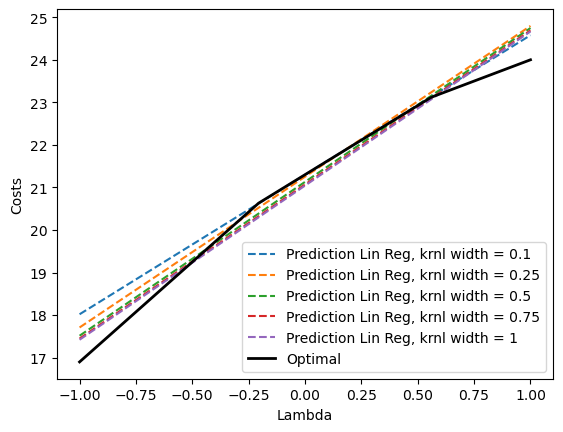

In [69]:
for kr_w in krnl_wdth[:-2]:
    plt.plot(x_test, outcome_d[str(kr_w)], label = 'Prediction Lin Reg, krnl width = ' + str(kr_w), linestyle = '--', linewidth =1.5) 

# plt.axvline(x = -0.3/1.45, ymax = 0.46, color ='grey', linestyle = (0,(1,3))) 
# plt.axvline(x = 0.7/1.25,  ymax = 0.75, color ='grey', linestyle = (0,(1,3))) 
plt.plot(x_test, y_rel, color = 'black', linestyle = '-', label = "Optimal", linewidth =2) 
plt.legend() 
plt.xlabel("Lambda")
plt.ylabel("Costs") 
plt.show()

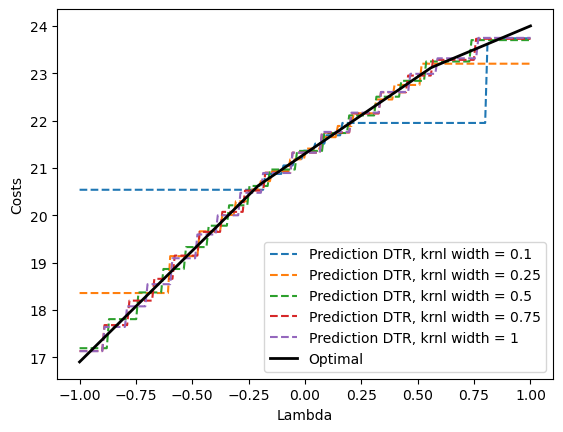

In [70]:
for kr_w in krnl_wdth[:-2]:
    plt.plot(x_test, outcome_d[str(kr_w)+ "DTR"], label = 'Prediction DTR, krnl width = ' + str(kr_w), linestyle = '--', linewidth =1.5) 

# plt.axvline(x = -0.3/1.45, ymax = 0.46, color ='grey', linestyle = (0,(1,3))) 
# plt.axvline(x = 0.7/1.25,  ymax = 0.75, color ='grey', linestyle = (0,(1,3))) 
plt.plot(x_test, y_rel, color = 'black', linestyle = '-', label = "Optimal", linewidth =2) 
plt.legend() 
plt.xlabel("Lambda")
plt.ylabel("Costs") 
plt.show()

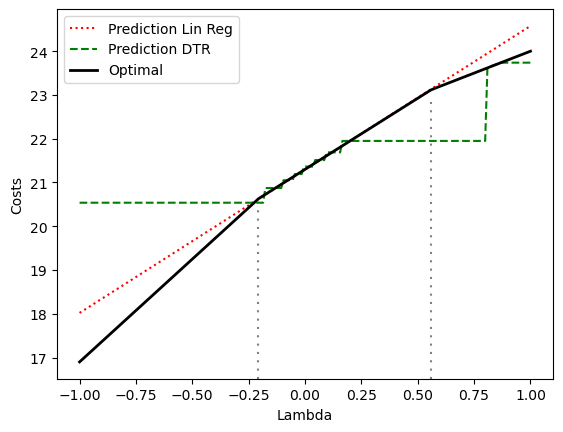

In [66]:
# Plot costs of different paths and found models
# for path in path_names[:6]:
#     plt.plot(x, path_costs[path], label = path, alpha = 0.5) 

plt.plot(x_test, outcome_d['0.1'], label = 'Prediction Lin Reg', linestyle = ':', color = 'r', linewidth =1.5) 
plt.plot(x_test, outcome_d['0.1'+ "DTR"], label = 'Prediction DTR', linestyle = '--', color ='g', linewidth =1.5) 
plt.axvline(x = -0.3/1.45, ymax = 0.46, color ='grey', linestyle = (0,(1,3))) 
plt.axvline(x = 0.7/1.25,  ymax = 0.75, color ='grey', linestyle = (0,(1,3))) 
plt.plot(x_test, y_rel, color = 'black', linestyle = '-', label = "Optimal", linewidth =2) 
plt.legend() 
plt.xlabel("Lambda")
plt.ylabel("Costs") 
plt.show()

# Structure as a feature

[('S', 'A'), ('A', 'D'), ('D', 'G'), ('G', 'T')]


{('S', 'A'): Text(0.5, 0.0, '6.5'),
 ('S', 'C'): Text(0.0, 0.5, '7.8'),
 ('A', 'B'): Text(1.5, 0.0, '7.5'),
 ('A', 'D'): Text(1.0, 0.5, '2.5'),
 ('B', 'E'): Text(2.0, 0.5, '1.5'),
 ('C', 'D'): Text(0.5, 1.0, '1.5'),
 ('C', 'F'): Text(0.0, 1.5, '2.3'),
 ('D', 'E'): Text(1.5, 1.0, '6.3'),
 ('D', 'G'): Text(1.0, 1.5, '4.1'),
 ('E', 'T'): Text(2.0, 1.5, '6.5'),
 ('F', 'G'): Text(0.5, 2.0, '4.5'),
 ('G', 'T'): Text(1.5, 2.0, '8.2')}

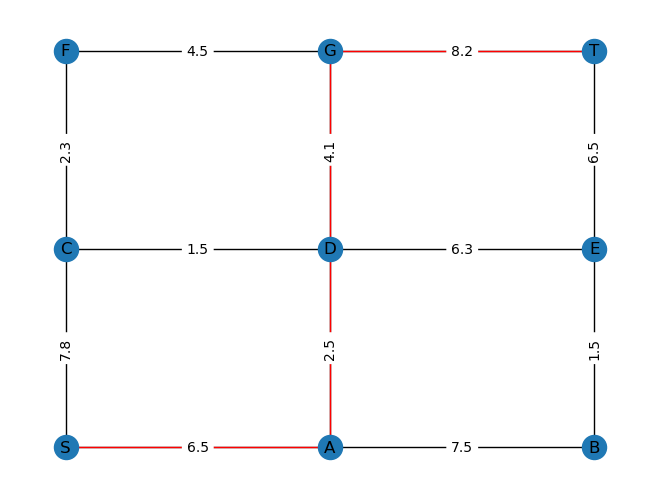

In [40]:
# Create graph plus plot structure
G = nx.Graph()
G.add_nodes_from(['S', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])
G.add_edges_from([  ("S", "A", {"weight": 6.5}), ("S", "C", {"weight": 7.8}), 
                    ("A", "B", {"weight": 7.5}), ("A", "D", {"weight": 2.5}),
                    ("C", "D", {"weight": 1.5}), ("C", "F", {"weight": 2.3}),
                    ("B", "E", {"weight": 1.5}), ("D", "E", {"weight": 6.3}),
                    ("D", "G", {"weight": 4.1}), ("F", "G", {"weight": 4.5}),
                    ("G", "T", {"weight": 8.2}), ("E", "T", {"weight": 6.5})])
edge_labels = nx.get_edge_attributes(G, "weight")
pos = {"S":(0,0), "A":(1,0),"B":(2,0),"C":(0,1),"D":(1,1),"E":(2,1),"F":(0,2),"G":(1,2), "T":(2,2)}
sp = nx.shortest_path(G, "S", "T", weight='weight')
e_sp = list(zip(sp,sp[1:]))
print(e_sp)
nx.draw(G, pos, with_labels = True)
nx.draw_networkx_edges(G, pos, edgelist=e_sp, edge_color="r")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

In [41]:
nx.to_latex(G,pos)

'\\documentclass{report}\n\\usepackage{tikz}\n\\usepackage{subcaption}\n\n\\begin{document}\n\\begin{figure}\n  \\begin{tikzpicture}\n      \\draw\n        (0, 0) node (S){S}\n        (1, 0) node (A){A}\n        (2, 0) node (B){B}\n        (0, 1) node (C){C}\n        (1, 1) node (D){D}\n        (2, 1) node (E){E}\n        (0, 2) node (F){F}\n        (1, 2) node (G){G}\n        (2, 2) node (T){T};\n      \\begin{scope}[-]\n        \\draw (S) to (A);\n        \\draw (S) to (C);\n        \\draw (A) to (B);\n        \\draw (A) to (D);\n        \\draw (B) to (E);\n        \\draw (C) to (D);\n        \\draw (C) to (F);\n        \\draw (D) to (E);\n        \\draw (D) to (G);\n        \\draw (E) to (T);\n        \\draw (F) to (G);\n        \\draw (G) to (T);\n      \\end{scope}\n    \\end{tikzpicture}\n\\end{figure}\n\\end{document}'

In [42]:
# Sample the strucure of the graph. Each edge remains with fixed probability
structure_sample = np.random.binomial(n = 1, p=0.85, size=[11000,12])

In [43]:
for w in krnl_wdth:
   print(w, round(kernel(np.ones(8), [1,1,1,1,1,1,1,0], w),5), round(kernel(np.ones(8), [1,1,1,1,1,1,0,0], w),5))

0.1 0.0 0.0
0.25 0.00034 0.0
0.5 0.13534 0.01832
0.75 0.41111 0.16901
1 0.60653 0.36788
1.25 0.72615 0.52729
1.5 0.80074 0.64118


In [44]:
# Check if graph structure still allows for a path from S to T
# Calculate shortest path
# Calculate weight based on kernel width and distance to original structure
 
opt = []
fsb_smpl = []
ins_wgt = [[],[],[],[],[],[],[],[]]

for i in range(len(structure_sample)):
    rmv_lst = []
    for j in range(len(structure_sample[i])):
        if structure_sample[i][j] == 0:
            rmv_lst.append(list(G.edges)[j])
    G_loc = copy.deepcopy(G)
    G_loc.remove_edges_from(rmv_lst)
    
    if nx.has_path(G_loc, "S", "T"):
        fsb_smpl.append(structure_sample[i])
        opt.append(nx.shortest_path_length(G_loc, "S", "T", weight='weight'))
        for w in range(len(krnl_wdth)):
            ins_wgt[w].append(kernel([1,1,1,1,1,1,1,1,1,1,1,1], structure_sample[i], krnl_wdth[w]))

In [45]:
print(len(fsb_smpl))

10239


In [46]:
# Split train and test set
# Train different kind of models with various hyperparameters

X_train, X_test, y_train, y_test =  train_test_split(fsb_smpl, opt,
                                                    train_size = 0.8, 
                                                    test_size = 0.2, 
                                                    random_state = 100)

ins_wgt_trn = [[],[],[],[],[],[],[]]
ins_wgt_tst = [[],[],[],[],[],[],[]]
for w in range(len(krnl_wdth)):
    for x_trn in X_train:
        ins_wgt_trn[w].append(kernel([1,1,1,1,1,1,1,1,1,1,1,1], x_trn, krnl_wdth[w]))
    for x_tst in X_test:
        ins_wgt_tst[w].append(kernel([1,1,1,1,1,1,1,1,1,1,1,1], x_tst, krnl_wdth[w]))

test_dict = {}
alphas    = [0.1, 0.5, 1, 1.5, 2]

for i in range(len(ins_wgt_trn)):
    test_dict['Kernel size ' + str(krnl_wdth[i])] = {}

    clf_LR = LinearRegression()
    clf_LR.fit(X_train, y_train, sample_weight=np.array(ins_wgt_trn[i]))

    y_pred = clf_LR.predict(X_test)
    score  = mean_squared_error(y_test, y_pred, sample_weight = ins_wgt_tst[i])
    test_dict['Kernel size ' + str(krnl_wdth[i])]['LinReg'] = {}
    test_dict['Kernel size ' + str(krnl_wdth[i])]['LinReg']['Score'] = score
    test_dict['Kernel size ' + str(krnl_wdth[i])]['LinReg']['Model'] = clf_LR
    test_dict['Kernel size ' + str(krnl_wdth[i])]['LinReg']['Coefficients'] = clf_LR.coef_
    print('Kernel size ' + str(krnl_wdth[i]), 'LinReg', 'Score', score)

    tree = DecisionTreeRegressor(random_state=0, max_depth=5, min_samples_leaf=50)
    tree.fit(X_train, y_train, sample_weight=np.array(ins_wgt_trn[i]))

    y_pred = tree.predict(X_test)
    score  = mean_squared_error(y_test, y_pred, sample_weight = ins_wgt_tst[i])

    test_dict['Kernel size ' + str(krnl_wdth[i])]['Tree'] = {}
    test_dict['Kernel size ' + str(krnl_wdth[i])]['Tree']['Score'] = score
    test_dict['Kernel size ' + str(krnl_wdth[i])]['Tree']['Model'] = tree
    test_dict['Kernel size ' + str(krnl_wdth[i])]['Tree']['Coefficients'] = tree.feature_importances_
    print('Kernel size ' + str(krnl_wdth[i]), 'Tree', 'Score', score)

    for alph in alphas:

        clf_RDG = Ridge(alpha=alph)        
        clf_RDG.fit(X_train, y_train, sample_weight=np.array(ins_wgt_trn[i]))
        
        y_pred = clf_RDG.predict(X_test)
        score  = mean_squared_error(y_test, y_pred, sample_weight = ins_wgt_tst[i])

        test_dict['Kernel size ' + str(krnl_wdth[i])]['Ridge ' + str(alph)] = {}
        test_dict['Kernel size ' + str(krnl_wdth[i])]['Ridge ' + str(alph)]['Score'] = score
        test_dict['Kernel size ' + str(krnl_wdth[i])]['Ridge ' + str(alph)]['Model'] = clf_RDG
        test_dict['Kernel size ' + str(krnl_wdth[i])]['Ridge ' + str(alph)]['Coefficients'] = clf_RDG.coef_
        print('Kernel size ' + str(krnl_wdth[i]), 'Ridge ' + str(alph), 'Score', score)

        clf_LSS = Lasso(alpha=alph)        
        clf_LSS.fit(X_train, y_train, sample_weight=np.array(ins_wgt_trn[i]))
        
        y_pred = clf_LSS.predict(X_test)
        score  = mean_squared_error(y_test, y_pred, sample_weight = ins_wgt_tst[i])

        test_dict['Kernel size ' + str(krnl_wdth[i])]['Lasso ' + str(alph)] = {}
        test_dict['Kernel size ' + str(krnl_wdth[i])]['Lasso ' + str(alph)]['Score'] = score
        test_dict['Kernel size ' + str(krnl_wdth[i])]['Lasso ' + str(alph)]['Model'] = clf_LSS
        test_dict['Kernel size ' + str(krnl_wdth[i])]['Lasso ' + str(alph)]['Coefficients'] = clf_LSS.coef_
        print('Kernel size ' + str(krnl_wdth[i]), 'Lasso ' + str(alph), 'Score', score)

Kernel size 0.1 LinReg Score 3.1914995242091124e-45
Kernel size 0.1 Tree Score 1.3977578040174917e-23
Kernel size 0.1 Ridge 0.1 Score 2.4651631053438446e-23
Kernel size 0.1 Lasso 0.1 Score 2.4651631053438446e-23
Kernel size 0.1 Ridge 0.5 Score 2.4651631053438446e-23
Kernel size 0.1 Lasso 0.5 Score 2.4651631053438446e-23
Kernel size 0.1 Ridge 1 Score 2.4651631053438446e-23
Kernel size 0.1 Lasso 1 Score 2.4651631053438446e-23
Kernel size 0.1 Ridge 1.5 Score 2.4651631053438446e-23
Kernel size 0.1 Lasso 1.5 Score 2.4651631053438446e-23
Kernel size 0.1 Ridge 2 Score 2.4651631053438446e-23
Kernel size 0.1 Lasso 2 Score 2.4651631053438446e-23
Kernel size 0.25 LinReg Score 9.72134333326121e-09
Kernel size 0.25 Tree Score 2.920667909968867e-10
Kernel size 0.25 Ridge 0.1 Score 1.3473629011617484e-05
Kernel size 0.25 Lasso 0.1 Score 4.288025198610471e-05
Kernel size 0.25 Ridge 0.5 Score 3.203177568897175e-05
Kernel size 0.25 Lasso 0.5 Score 4.288025198610471e-05
Kernel size 0.25 Ridge 1 Score 3.6

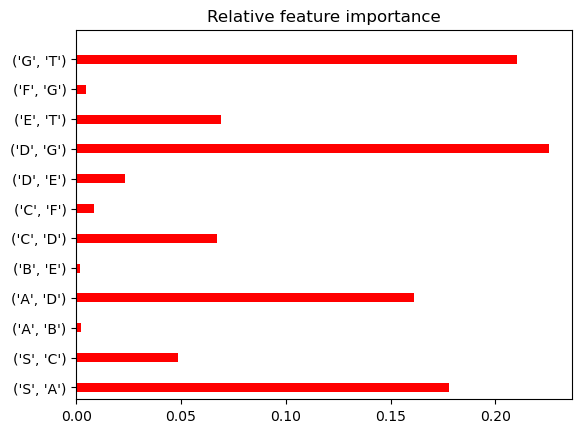

In [47]:
# Print feature importance best fitting model
# Normalize coefficients to get feature importance
model = test_dict['Kernel size ' + str(1)]['LinReg']['Model']
ftr_imp = np.abs(model.coef_)/np.sum(np.abs(model.coef_))

# Plot feature importance
ind = np.arange(12)
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, ftr_imp, width, color='red')
ax.set(yticks=ind , yticklabels=list(G.edges), ylim=[2*width - 1, 12])
plt.title('Relative feature importance')
plt.show()

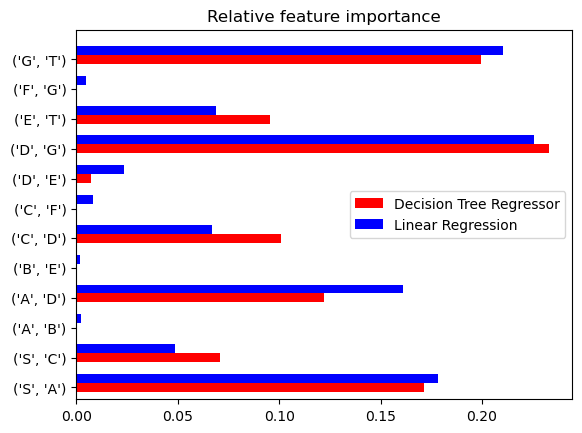

In [48]:
# Print feature importance best fitting model
# Normalize coefficients to get feature importance
model_1 = test_dict['Kernel size ' + str(1)]['Tree']['Model']
ftr_imp_1 = np.abs(model_1.feature_importances_)
model_2 = test_dict['Kernel size ' + str(1)]['LinReg']['Model']
ftr_imp_2 = np.abs(model_2.coef_)/np.sum(np.abs(model_2.coef_))

# Plot feature importance
ind = np.arange(12)
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, ftr_imp_1, width, color='red', label = 'Decision Tree Regressor')
ax.barh(ind + width, ftr_imp_2, width, color='blue', label = 'Linear Regression')
ax.set(yticks=ind , yticklabels=list(G.edges), ylim=[2*width - 1, 12])
plt.legend()
plt.title('Relative feature importance')
plt.show()

# Overall cost sampling

Sampling is done in 3 different ways: 
A) Change cost parameters with lambda times as fixed epsilon, where lambda is stochastic. Distance is measured in terms of lambda
B) Change cost parameters by adding a random variable with mean 0 and std dev related to size of the cost parameter. Distance is measured wrt original cost parameter
C) Change cost parameters by by rescaling it with a random variable lambda. Distance is measured in terms of lambda

In [55]:
# Method A

costs_G = np.array(list(nx.get_edge_attributes(G, 'weight').values()))
edges_G = list(nx.get_edge_attributes(G, 'weight').keys())
dict_G  = nx.get_edge_attributes(G, 'weight')

eps = 1.5

prt_A = []
opt_A = []
wgt_A = [[],[],[],[],[],[],[]]

for i in range(10000):
    G_loc = copy.deepcopy(G)
    prt_A.append(np.zeros(len(edges_G)))

    for j in range(len(edges_G)):
        lmb = np.random.uniform(-1, 1)
        edge  = edges_G[j]
        G_loc.edges[edge]['weight'] = max(0, G.edges[edge]['weight'] + lmb*eps)
        prt_A[i][j] = lmb

    opt_A.append(nx.shortest_path_length(G_loc, "S", "T", weight='weight'))
    for w in range(len(krnl_wdth)):
        wgt_A[w].append(kernel(np.zeros(len(edges_G)), prt_A[i], krnl_wdth[w]))

In [56]:
# Split train and test set
# Train different kind of models with various hyperparameters

X_train, X_test, y_train, y_test =  train_test_split(prt_A, opt_A,
                                                    train_size = 0.8, 
                                                    test_size = 0.2, 
                                                    random_state = 100)

ins_wgt_trn = [[],[],[],[],[],[],[]]
ins_wgt_tst = [[],[],[],[],[],[],[]]
for w in range(len(krnl_wdth)):
    for x_trn in X_train:
        ins_wgt_trn[w].append(kernel(np.zeros(len(edges_G)), x_trn, krnl_wdth[w]))
    for x_tst in X_test:
        ins_wgt_tst[w].append(kernel(np.zeros(len(edges_G)), x_tst, krnl_wdth[w]))

test_dict_c_A = {}
alphas    = [0.1, 0.5, 1, 1.5, 2]

for i in range(len(ins_wgt_trn)):
    test_dict_c_A['Kernel size ' + str(krnl_wdth[i])] = {}

    clf_LR = LinearRegression()
    clf_LR.fit(X_train, y_train, sample_weight=np.array(ins_wgt_trn[i]))

    y_pred = clf_LR.predict(X_test)
    score  = mean_squared_error(y_test, y_pred, sample_weight = ins_wgt_tst[i])
    test_dict_c_A['Kernel size ' + str(krnl_wdth[i])]['LinReg'] = {}
    test_dict_c_A['Kernel size ' + str(krnl_wdth[i])]['LinReg']['Score'] = score
    test_dict_c_A['Kernel size ' + str(krnl_wdth[i])]['LinReg']['Model'] = clf_LR
    test_dict_c_A['Kernel size ' + str(krnl_wdth[i])]['LinReg']['Coefficients'] = clf_LR.coef_
    print('Kernel size ' + str(krnl_wdth[i]), 'LinReg', 'Score', score)

    tree = DecisionTreeRegressor(random_state=0, max_depth=5, min_samples_leaf=50)
    tree.fit(X_train, y_train, sample_weight=np.array(ins_wgt_trn[i]))

    y_pred = tree.predict(X_test)
    score  = mean_squared_error(y_test, y_pred, sample_weight = ins_wgt_tst[i])

    test_dict_c_A['Kernel size ' + str(krnl_wdth[i])]['Tree'] = {}
    test_dict_c_A['Kernel size ' + str(krnl_wdth[i])]['Tree']['Score'] = score
    test_dict_c_A['Kernel size ' + str(krnl_wdth[i])]['Tree']['Model'] = tree
    test_dict_c_A['Kernel size ' + str(krnl_wdth[i])]['Tree']['Coefficients'] = tree.feature_importances_
    print('Kernel size ' + str(krnl_wdth[i]), 'Tree', 'Score', score)

    for alph in alphas:

        clf_RDG = Ridge(alpha=alph)        
        clf_RDG.fit(X_train, y_train, sample_weight=np.array(ins_wgt_trn[i]))
        
        y_pred = clf_RDG.predict(X_test)
        score  = mean_squared_error(y_test, y_pred, sample_weight = ins_wgt_tst[i])

        test_dict_c_A['Kernel size ' + str(krnl_wdth[i])]['Ridge ' + str(alph)] = {}
        test_dict_c_A['Kernel size ' + str(krnl_wdth[i])]['Ridge ' + str(alph)]['Score'] = score
        test_dict_c_A['Kernel size ' + str(krnl_wdth[i])]['Ridge ' + str(alph)]['Model'] = clf_RDG
        test_dict_c_A['Kernel size ' + str(krnl_wdth[i])]['Ridge ' + str(alph)]['Coefficients'] = clf_RDG.coef_
        print('Kernel size ' + str(krnl_wdth[i]), 'Ridge ' + str(alph), 'Score', score)

        clf_LSS = Lasso(alpha=alph)        
        clf_LSS.fit(X_train, y_train, sample_weight=np.array(ins_wgt_trn[i]))
        
        y_pred = clf_LSS.predict(X_test)
        score  = mean_squared_error(y_test, y_pred, sample_weight = ins_wgt_tst[i])

        test_dict_c_A['Kernel size ' + str(krnl_wdth[i])]['Lasso ' + str(alph)] = {}
        test_dict_c_A['Kernel size ' + str(krnl_wdth[i])]['Lasso ' + str(alph)]['Score'] = score
        test_dict_c_A['Kernel size ' + str(krnl_wdth[i])]['Lasso ' + str(alph)]['Model'] = clf_LSS
        test_dict_c_A['Kernel size ' + str(krnl_wdth[i])]['Lasso ' + str(alph)]['Coefficients'] = clf_LSS.coef_
        print('Kernel size ' + str(krnl_wdth[i]), 'Lasso ' + str(alph), 'Score', score)

Kernel size 0.1 LinReg Score 0.01250297956609851
Kernel size 0.1 Tree Score 0.12209847315148838
Kernel size 0.1 Ridge 0.1 Score 0.37171737284987794
Kernel size 0.1 Lasso 0.1 Score 0.37171737284987794
Kernel size 0.1 Ridge 0.5 Score 0.37171737284987794
Kernel size 0.1 Lasso 0.5 Score 0.37171737284987794
Kernel size 0.1 Ridge 1 Score 0.37171737284987794
Kernel size 0.1 Lasso 1 Score 0.37171737284987794
Kernel size 0.1 Ridge 1.5 Score 0.37171737284987794
Kernel size 0.1 Lasso 1.5 Score 0.37171737284987794
Kernel size 0.1 Ridge 2 Score 0.37171737284987794
Kernel size 0.1 Lasso 2 Score 0.37171737284987794
Kernel size 0.25 LinReg Score 0.14952318088805786
Kernel size 0.25 Tree Score 1.1706834978602498
Kernel size 0.25 Ridge 0.1 Score 0.5174514496192291
Kernel size 0.25 Lasso 0.1 Score 0.5265831457636485
Kernel size 0.25 Ridge 0.5 Score 0.5247003555125658
Kernel size 0.25 Lasso 0.5 Score 0.5265831457636485
Kernel size 0.25 Ridge 1 Score 0.5256381025078183
Kernel size 0.25 Lasso 1 Score 0.5265

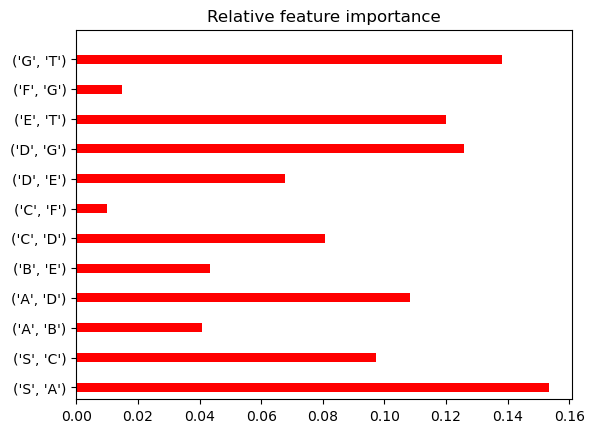

In [57]:
# Normalize coefficients to get feature importance
ftr_imp = np.abs(test_dict_c_A['Kernel size ' + str(1)]['Ridge ' + str(0.1)]['Coefficients'])/np.sum(np.abs(test_dict_c_A['Kernel size ' + str(1)]['Ridge ' + str(0.1)]['Coefficients']))

# Plot feature importance
ind = np.arange(12)
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, ftr_imp, width, color='red')
ax.set(yticks=ind , yticklabels=list(G.edges), ylim=[2*width - 1, 12])
plt.title('Relative feature importance')
plt.show()

In [58]:
# Method B

costs_G = np.array(list(nx.get_edge_attributes(G, 'weight').values()))
edges_G = list(nx.get_edge_attributes(G, 'weight').keys())
dict_G  = nx.get_edge_attributes(G, 'weight')

mu = 0
var = 0.3

prt_B = []
opt_B = []
wgt_B = [[],[],[],[],[],[],[]]

for i in range(10000):
    G_loc = copy.deepcopy(G)
    prt_B.append(np.zeros(len(edges_G)))

    for j in range(len(edges_G)):
        edge  = edges_G[j]
        var_loc = G.edges[edge]['weight'] * var
        G_loc.edges[edge]['weight'] = max(0, G.edges[edge]['weight'] + np.random.normal(mu,var_loc))
        prt_B[i][j] = G_loc.edges[edge]['weight']

    opt_B.append(nx.shortest_path_length(G_loc, "S", "T", weight='weight'))
    for w in range(len(krnl_wdth)):
        wgt_B[w].append(kernel(list(nx.get_edge_attributes(G, 'weight').values()), prt_B[i], krnl_wdth[w]))

In [59]:
# Split train and test set
# Train different kind of models with various hyperparameters

X_train, X_test, y_train, y_test =  train_test_split(prt_B, opt_B,
                                                    train_size = 0.8, 
                                                    test_size = 0.2, 
                                                    random_state = 100)

ins_wgt_trn = [[],[],[],[],[],[],[]]
ins_wgt_tst = [[],[],[],[],[],[],[]]
for w in range(len(krnl_wdth)):
    for x_trn in X_train:
        ins_wgt_trn[w].append(kernel(list(nx.get_edge_attributes(G, 'weight').values()), x_trn, krnl_wdth[w]))
    for x_tst in X_test:
        ins_wgt_tst[w].append(kernel(list(nx.get_edge_attributes(G, 'weight').values()), x_tst, krnl_wdth[w]))

test_dict_c_B = {}
alphas    = [0.1, 0.5, 1, 1.5, 2]

for i in range(len(ins_wgt_trn)):
    test_dict_c_B['Kernel size ' + str(krnl_wdth[i])] = {}

    clf_LR = LinearRegression()
    clf_LR.fit(X_train, y_train, sample_weight=np.array(ins_wgt_trn[i]))

    y_pred = clf_LR.predict(X_test)
    score  = mean_squared_error(y_test, y_pred, sample_weight = ins_wgt_tst[i])
    test_dict_c_B['Kernel size ' + str(krnl_wdth[i])]['LinReg'] = {}
    test_dict_c_B['Kernel size ' + str(krnl_wdth[i])]['LinReg']['Score'] = score
    test_dict_c_B['Kernel size ' + str(krnl_wdth[i])]['LinReg']['Model'] = clf_LR
    test_dict_c_B['Kernel size ' + str(krnl_wdth[i])]['LinReg']['Coefficients'] = clf_LR.coef_
    print('Kernel size ' + str(krnl_wdth[i]), 'LinReg', 'Score', score)

    tree = DecisionTreeRegressor(random_state=0, max_depth=5, min_samples_leaf=50)
    tree.fit(X_train, y_train, sample_weight=np.array(ins_wgt_trn[i]))

    y_pred = tree.predict(X_test)
    score  = mean_squared_error(y_test, y_pred, sample_weight = ins_wgt_tst[i])

    test_dict_c_B['Kernel size ' + str(krnl_wdth[i])]['Tree'] = {}
    test_dict_c_B['Kernel size ' + str(krnl_wdth[i])]['Tree']['Score'] = score
    test_dict_c_B['Kernel size ' + str(krnl_wdth[i])]['Tree']['Model'] = tree
    test_dict_c_B['Kernel size ' + str(krnl_wdth[i])]['Tree']['Coefficients'] = tree.feature_importances_
    print('Kernel size ' + str(krnl_wdth[i]), 'Tree', 'Score', score)

    for alph in alphas:

        clf_RDG = Ridge(alpha=alph)        
        clf_RDG.fit(X_train, y_train, sample_weight=np.array(ins_wgt_trn[i]))
        
        y_pred = clf_RDG.predict(X_test)
        score  = mean_squared_error(y_test, y_pred, sample_weight = ins_wgt_tst[i])

        test_dict_c_B['Kernel size ' + str(krnl_wdth[i])]['Ridge ' + str(alph)] = {}
        test_dict_c_B['Kernel size ' + str(krnl_wdth[i])]['Ridge ' + str(alph)]['Score'] = score
        test_dict_c_B['Kernel size ' + str(krnl_wdth[i])]['Ridge ' + str(alph)]['Model'] = clf_RDG
        test_dict_c_B['Kernel size ' + str(krnl_wdth[i])]['Ridge ' + str(alph)]['Coefficients'] = clf_RDG.coef_
        print('Kernel size ' + str(krnl_wdth[i]), 'Ridge ' + str(alph), 'Score', score)

        clf_LSS = Lasso(alpha=alph)        
        clf_LSS.fit(X_train, y_train, sample_weight=np.array(ins_wgt_trn[i]))
        
        y_pred = clf_LSS.predict(X_test)
        score  = mean_squared_error(y_test, y_pred, sample_weight = ins_wgt_tst[i])

        test_dict_c_B['Kernel size ' + str(krnl_wdth[i])]['Lasso ' + str(alph)] = {}
        test_dict_c_B['Kernel size ' + str(krnl_wdth[i])]['Lasso ' + str(alph)]['Score'] = score
        test_dict_c_B['Kernel size ' + str(krnl_wdth[i])]['Lasso ' + str(alph)]['Model'] = clf_LSS
        test_dict_c_B['Kernel size ' + str(krnl_wdth[i])]['Lasso ' + str(alph)]['Coefficients'] = clf_LSS.coef_
        print('Kernel size ' + str(krnl_wdth[i]), 'Lasso ' + str(alph), 'Score', score)

Kernel size 0.1 LinReg Score 2.6070851829475163
Kernel size 0.1 Tree Score 0.5194017191586109
Kernel size 0.1 Ridge 0.1 Score 0.4474018511027302
Kernel size 0.1 Lasso 0.1 Score 0.44740185110272546
Kernel size 0.1 Ridge 0.5 Score 0.4474018511027302
Kernel size 0.1 Lasso 0.5 Score 0.44740185110272546
Kernel size 0.1 Ridge 1 Score 0.4474018511027302
Kernel size 0.1 Lasso 1 Score 0.44740185110272546
Kernel size 0.1 Ridge 1.5 Score 0.4474018511027302
Kernel size 0.1 Lasso 1.5 Score 0.44740185110272546
Kernel size 0.1 Ridge 2 Score 0.4474018511027302
Kernel size 0.1 Lasso 2 Score 0.44740185110272546
Kernel size 0.25 LinReg Score 2.9327345914430087
Kernel size 0.25 Tree Score 0.27305564460937065
Kernel size 0.25 Ridge 0.1 Score 0.27305569901360593
Kernel size 0.25 Lasso 0.1 Score 0.27305564460934834
Kernel size 0.25 Ridge 0.5 Score 0.2730556554902187
Kernel size 0.25 Lasso 0.5 Score 0.27305564460934834
Kernel size 0.25 Ridge 1 Score 0.27305565004978904
Kernel size 0.25 Lasso 1 Score 0.2730556

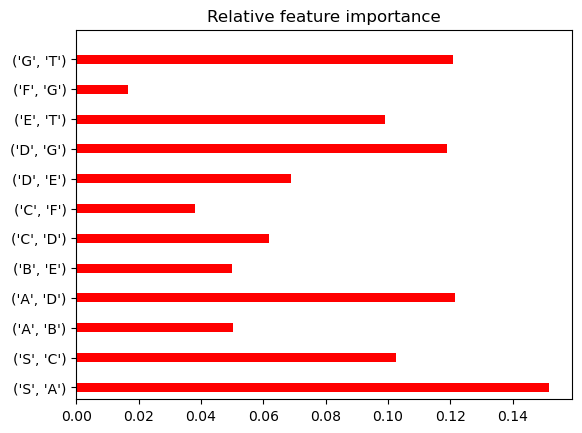

In [60]:
# Normalize coefficients to get feature importance
ftr_imp = np.abs(test_dict_c_B['Kernel size ' + str(1)]['LinReg']['Coefficients'])/np.sum(np.abs(test_dict_c_B['Kernel size ' + str(1)]['LinReg']['Coefficients']))

# Plot feature importance
ind = np.arange(12)
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, ftr_imp, width, color='red')
ax.set(yticks=ind , yticklabels=list(G.edges), ylim=[2*width - 1, 12])
plt.title('Relative feature importance')
plt.show()

In [61]:
# Method C

costs_G = np.array(list(nx.get_edge_attributes(G, 'weight').values()))
edges_G = list(nx.get_edge_attributes(G, 'weight').keys())
dict_G  = nx.get_edge_attributes(G, 'weight')

prt_C = []
opt_C = []
wgt_C = [[],[],[],[],[],[],[]]

for i in range(10000):
    G_loc = copy.deepcopy(G)
    prt_C.append(np.zeros(len(edges_G)))

    for j in range(len(edges_G)):
        lmb = np.random.uniform(0.1, 2)
        edge  = edges_G[j]
        G_loc.edges[edge]['weight'] = max(0, G.edges[edge]['weight'] * lmb)
        prt_C[i][j] = lmb

    opt_C.append(nx.shortest_path_length(G_loc, "S", "T", weight='weight'))
    for w in range(len(krnl_wdth)):
        wgt_C[w].append(kernel(np.ones(len(edges_G)), prt_C[i], krnl_wdth[w]))

In [62]:
# Split train and test set
# Train different kind of models with various hyperparameters

X_train, X_test, y_train, y_test =  train_test_split(prt_C, opt_C,
                                                    train_size = 0.8, 
                                                    test_size = 0.2, 
                                                    random_state = 100)

ins_wgt_trn = [[],[],[],[],[],[],[]]
ins_wgt_tst = [[],[],[],[],[],[],[]]
for w in range(len(krnl_wdth)):
    for x_trn in X_train:
        ins_wgt_trn[w].append(kernel(np.ones(len(edges_G)), x_trn, krnl_wdth[w]))
    for x_tst in X_test:
        ins_wgt_tst[w].append(kernel(np.ones(len(edges_G)), x_tst, krnl_wdth[w]))

test_dict_c_C = {}
alphas    = [0.1, 0.5, 1, 1.5, 2]

for i in range(len(ins_wgt_trn)):
    test_dict_c_C['Kernel size ' + str(krnl_wdth[i])] = {}

    clf_LR = LinearRegression()
    clf_LR.fit(X_train, y_train, sample_weight=np.array(ins_wgt_trn[i]))

    y_pred = clf_LR.predict(X_test)
    score  = mean_squared_error(y_test, y_pred, sample_weight = ins_wgt_tst[i])
    test_dict_c_C['Kernel size ' + str(krnl_wdth[i])]['LinReg'] = {}
    test_dict_c_C['Kernel size ' + str(krnl_wdth[i])]['LinReg']['Score'] = score
    test_dict_c_C['Kernel size ' + str(krnl_wdth[i])]['LinReg']['Model'] = clf_LR
    test_dict_c_C['Kernel size ' + str(krnl_wdth[i])]['LinReg']['Coefficients'] = clf_LR.coef_
    print('Kernel size ' + str(krnl_wdth[i]), 'LinReg', 'Score', score)

    tree = DecisionTreeRegressor(random_state=0, max_depth=5, min_samples_leaf=50)
    tree.fit(X_train, y_train, sample_weight=np.array(ins_wgt_trn[i]))

    y_pred = tree.predict(X_test)
    score  = mean_squared_error(y_test, y_pred, sample_weight = ins_wgt_tst[i])

    test_dict_c_C['Kernel size ' + str(krnl_wdth[i])]['Tree'] = {}
    test_dict_c_C['Kernel size ' + str(krnl_wdth[i])]['Tree']['Score'] = score
    test_dict_c_C['Kernel size ' + str(krnl_wdth[i])]['Tree']['Model'] = tree
    test_dict_c_C['Kernel size ' + str(krnl_wdth[i])]['Tree']['Coefficients'] = tree.feature_importances_
    print('Kernel size ' + str(krnl_wdth[i]), 'Tree', 'Score', score)

    for alph in alphas:

        clf_RDG = Ridge(alpha=alph)        
        clf_RDG.fit(X_train, y_train, sample_weight=np.array(ins_wgt_trn[i]))
        
        y_pred = clf_RDG.predict(X_test)
        score  = mean_squared_error(y_test, y_pred, sample_weight = ins_wgt_tst[i])

        test_dict_c_C['Kernel size ' + str(krnl_wdth[i])]['Ridge ' + str(alph)] = {}
        test_dict_c_C['Kernel size ' + str(krnl_wdth[i])]['Ridge ' + str(alph)]['Score'] = score
        test_dict_c_C['Kernel size ' + str(krnl_wdth[i])]['Ridge ' + str(alph)]['Model'] = clf_RDG
        test_dict_c_C['Kernel size ' + str(krnl_wdth[i])]['Ridge ' + str(alph)]['Coefficients'] = clf_RDG.coef_
        print('Kernel size ' + str(krnl_wdth[i]), 'Ridge ' + str(alph), 'Score', score)

        clf_LSS = Lasso(alpha=alph)        
        clf_LSS.fit(X_train, y_train, sample_weight=np.array(ins_wgt_trn[i]))
        
        y_pred = clf_LSS.predict(X_test)
        score  = mean_squared_error(y_test, y_pred, sample_weight = ins_wgt_tst[i])

        test_dict_c_C['Kernel size ' + str(krnl_wdth[i])]['Lasso ' + str(alph)] = {}
        test_dict_c_C['Kernel size ' + str(krnl_wdth[i])]['Lasso ' + str(alph)]['Score'] = score
        test_dict_c_C['Kernel size ' + str(krnl_wdth[i])]['Lasso ' + str(alph)]['Model'] = clf_LSS
        test_dict_c_C['Kernel size ' + str(krnl_wdth[i])]['Lasso ' + str(alph)]['Coefficients'] = clf_LSS.coef_
        print('Kernel size ' + str(krnl_wdth[i]), 'Lasso ' + str(alph), 'Score', score)

Kernel size 0.1 LinReg Score 1.8973777045731492
Kernel size 0.1 Tree Score 4.662973209012328
Kernel size 0.1 Ridge 0.1 Score 4.663053342881183
Kernel size 0.1 Lasso 0.1 Score 4.663053342881183
Kernel size 0.1 Ridge 0.5 Score 4.663053342881183
Kernel size 0.1 Lasso 0.5 Score 4.663053342881183
Kernel size 0.1 Ridge 1 Score 4.663053342881183
Kernel size 0.1 Lasso 1 Score 4.663053342881183
Kernel size 0.1 Ridge 1.5 Score 4.663053342881183
Kernel size 0.1 Lasso 1.5 Score 4.663053342881183
Kernel size 0.1 Ridge 2 Score 4.663053342881183
Kernel size 0.1 Lasso 2 Score 4.663053342881183
Kernel size 0.25 LinReg Score 1.8485688233191577
Kernel size 0.25 Tree Score 8.40748352380351
Kernel size 0.25 Ridge 0.1 Score 5.379055368984682
Kernel size 0.25 Lasso 0.1 Score 4.523054353013013
Kernel size 0.25 Ridge 0.5 Score 5.445161887342679
Kernel size 0.25 Lasso 0.5 Score 5.002288524615961
Kernel size 0.25 Ridge 1 Score 5.453674214315773
Kernel size 0.25 Lasso 1 Score 5.462243558452669
Kernel size 0.25 Ri

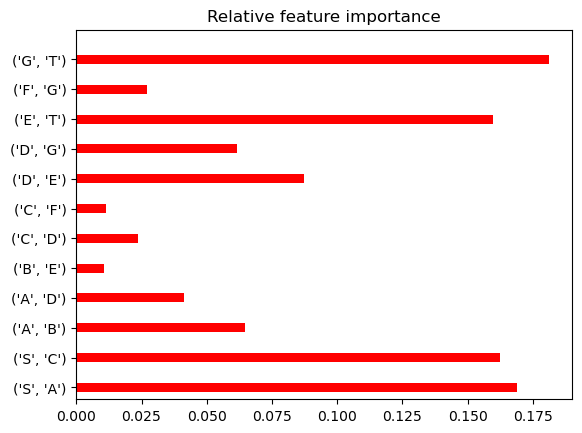

In [63]:
# Normalize coefficients to get feature importance
ftr_imp = np.abs(test_dict_c_C['Kernel size ' + str(1)]['LinReg']['Coefficients'])/np.sum(np.abs(test_dict_c_C['Kernel size ' + str(1)]['LinReg']['Coefficients']))

# Plot feature importance
ind = np.arange(12)
width = 0.3

fig, ax = plt.subplots()
ax.barh(ind, ftr_imp, width, color='red')
ax.set(yticks=ind , yticklabels=list(G.edges), ylim=[2*width - 1, 12])
plt.title('Relative feature importance')
plt.show()

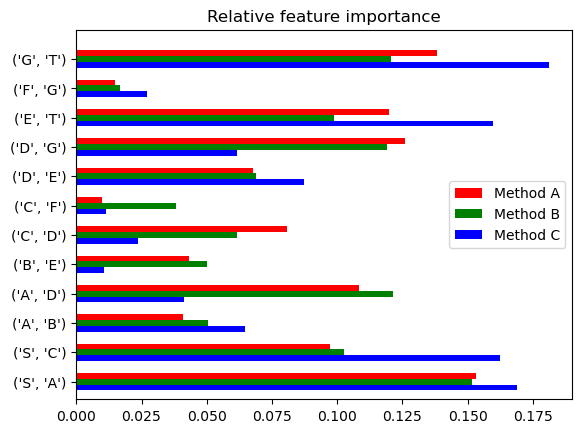

In [64]:
# Normalize coefficients to get feature importance
model = test_dict['Kernel size ' + str(1)]['LinReg']['Model']
# ftr_imp_S = np.abs(model.coef_)/np.sum(np.abs(model.coef_))
ftr_imp_A = np.abs(test_dict_c_A['Kernel size ' + str(1)]['LinReg']['Coefficients'])/np.sum(np.abs(test_dict_c_A['Kernel size ' + str(1)]['LinReg']['Coefficients']))
ftr_imp_B = np.abs(test_dict_c_B['Kernel size ' + str(1)]['LinReg']['Coefficients'])/np.sum(np.abs(test_dict_c_B['Kernel size ' + str(1)]['LinReg']['Coefficients']))
ftr_imp_C = np.abs(test_dict_c_C['Kernel size ' + str(1)]['LinReg']['Coefficients'])/np.sum(np.abs(test_dict_c_C['Kernel size ' + str(1)]['LinReg']['Coefficients']))

# Plot feature importance
ind = np.arange(12)
width = 0.2

fig, ax = plt.subplots()
# ax.barh(ind + 2* width, ftr_imp_S, width, color='grey', label= 'Structure')
ax.barh(ind + width, ftr_imp_A, width, color='red', label= 'Method A')
ax.barh(ind        , ftr_imp_B, width, color='green', label='Method B')
ax.barh(ind - width, ftr_imp_C, width, color='blue', label='Method C')
ax.set(yticks=ind , yticklabels=list(G.edges), ylim=[2*width - 1, 12])
ax.legend()
plt.title('Relative feature importance')
plt.show()